# Real World Inference

In [11]:
import sys
import os
sys.path.append("../") # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import numpy as np
from scipy.stats import rankdata
import scipy.stats as ss
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import KFold
from tqdm import tqdm

# from data.create_sim_data import *
import data.template_causl_simulations as causl_py
from data.run_all_simulations import plot_simulation_results
from data.analysis.validationMethods import matchit
from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow
from frugal_flows.bijections import UnivariateNormalCDF

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
from rpy2.robjects.vectors import StrVector

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()
base = importr('base')
utils = importr('utils')

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))

jax.config.update("jax_enable_x64", True)

hyperparams_dict = {
    'learning_rate': 5e-3,
    'RQS_knots': 8,
    'flow_layers': 5,
    'nn_width': 50,
    'nn_depth': 4,    
    'max_patience': 100,
    'max_epochs': 10000
}
causal_margin_hyperparams_dict = {
    'RQS_knots': 4,
    'flow_layers': 8,
    'nn_depth': 10,    
    'nn_width': 50,
}

SEED = 0
NUM_ITER = 25
NUM_SAMPLES = 25000
TRUE_PARAMS = {'ate': 1, 'const': 0, 'scale': 1}
CAUSAL_PARAMS = [5, 5]

In [2]:
def run_outcome_regression(data):
    Z_cont = data.get('Z_cont', None)
    Z_disc = data.get('Z_disc', None)
    if Z_cont == None:
        Z_full = Z_disc
    elif Z_disc == None:
        Z_full = Z_cont
    else:
        Z_full = jnp.hstack([Z_cont, Z_disc])
    Z_cols = [f"Z{i+1}" for i in range(Z_full.shape[1])]
    df = pd.DataFrame(jnp.hstack([data['Y'], data['X'], Z_full]), columns=['Y', 'X', *Z_cols])
    X_vars = df[['X', *Z_cols]]
    X_vars = sm.add_constant(X_vars)
    Y_var = df['Y']
    model = sm.OLS(Y_var, X_vars).fit()
    coefficient_X = model.params['X']
    coefficient_const = model.params['const']
    return coefficient_X, coefficient_const

In [3]:
def dict_to_dataframe(data):
    # Extract the data from the dictionary
    X = np.array(data['X']).flatten()
    Y = np.array(data['Y']).flatten()
    
    # Initialize a dictionary to construct the DataFrame
    df_dict = {'X': X, 'Y': Y}
    
    # Initialize the Z column index
    z_index = 1
    
    # Process Z_cont
    if 'Z_cont' in data and data['Z_cont'] is not None:
        Z_cont = np.array(data['Z_cont'])
        for i in range(Z_cont.shape[1]):
            df_dict[f'Z{z_index}'] = Z_cont[:, i]
            z_index += 1
    
    # Process Z_disc (assuming similar structure if it were present)
    if 'Z_disc' in data and data['Z_disc'] is not None:
        Z_disc = np.array(data['Z_disc'])
        for i in range(Z_disc.shape[1]):
            df_dict[f'Z{z_index}'] = Z_disc[:, i]
            z_index += 1
    
    # Create the DataFrame
    df = pd.DataFrame(df_dict)
    
    return df

## Testing Relationship between Inference and Datasize

In [20]:
Z_disc, Z_cont, X, Y = causl_py.generate_discrete_samples(5000, CAUSAL_PARAMS, N_test).values()
uz_samples = causl_py.generate_uz_samples(Z_cont=Z_cont, Z_disc=Z_disc, use_marginal_flow=False, seed=0, frugal_flow_hyperparams=hyperparams_dict)

frugal_flow, losses = causl_py.train_frugal_flow(
    key=jr.PRNGKey(0),
    y=Y,
    u_z=uz_samples['uz_samples'],
    # u_z = jr.uniform(jr.PRNGKey(1000), shape=(N_test, 4)),
    condition=X,
    **hyperparams_dict,
    # causal_model='gaussian',
    # causal_model_args={'ate': jnp.array([causal_model_args['ate']]), 'const': causal_model_args['const'], 'scale': causal_model_args['scale']}
    causal_model='location_translation',
    causal_model_args={'ate': 0., **causal_margin_hyperparams_dict},

)

  3%|███▏                                                                                            | 337/10000 [03:47<1:48:49,  1.48it/s, train=1.0239194868408086, val=1.3292911565926084 (Max patience reached)]


In [40]:
causal_model_args = {'ate': -10.0, 'const': -10.0, 'scale': 10.0}
Nrange_space = np.linspace(start=100, stop=20000, num=25).astype(int)
results_list = {'ate': [], 'const': [], 'scale': []}

for N_test in Nrange_space:
    Z_disc, Z_cont, X, Y = causl_py.generate_discrete_samples(N_test, CAUSAL_PARAMS, N_test).values()
    uz_samples = causl_py.generate_uz_samples(Z_cont=Z_cont, Z_disc=Z_disc, use_marginal_flow=False, seed=0, frugal_flow_hyperparams=hyperparams_dict)
    frugal_flow, losses = causl_py.train_frugal_flow(
        key=jr.PRNGKey(0),
        y=Y,
        u_z=uz_samples['uz_samples'],
        # u_z = jr.uniform(jr.PRNGKey(1000), shape=(N_test, 4)),
        condition=X,
        **hyperparams_dict,
        # causal_model='gaussian',
        # causal_model_args={'ate': jnp.array([causal_model_args['ate']]), 'const': causal_model_args['const'], 'scale': causal_model_args['scale']}
        causal_model='location_translation',
        causal_model_args={'ate': causal_model_args['ate'], **causal_margin_hyperparams_dict},

    )
    # causal_margin = frugal_flow.bijection.bijections[-1].bijection.bijections[0]
    # results_list['ate'].append(causal_margin.ate[0])
    results_list['ate'].append(frugal_flow.bijection.bijections[-1].bijections[0].ate)    
    # results_list['const'].append(causal_margin.const)
    # results_list['scale'].append(causal_margin.scale)

  3%|██▊                                                                                             | 290/10000 [09:06<5:05:03,  1.89s/it, train=1.1564635428034309, val=1.1616889441117948 (Max patience reached)]


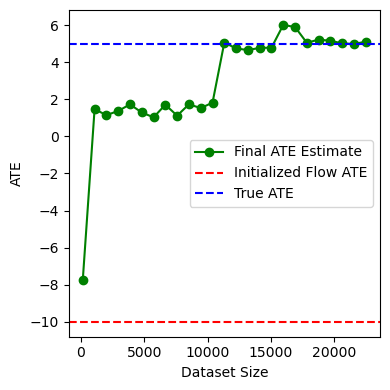

In [63]:
# Create the plot
fig, axs = plt.subplots(1, 1, figsize=(4, 4))

# Plot ATE
axs.plot(Nrange_space*3/2, results_list['ate'], marker='o', label='Final ATE Estimate', color='green')
axs.axhline(y=causal_model_args['ate'], color='red', linestyle='--', label='Initialized Flow ATE')
axs.axhline(y=5, color='blue', linestyle='--', label='True ATE')
axs.set_xlabel('Dataset Size')
axs.set_ylabel('ATE')
# axs.set_title('ATE as a function of Nrange_space')
axs.legend()

# # Plot ATE
# axs[0].plot(Nrange_space, results_list['ate'], marker='o', label='ATE')
# axs[0].axhline(y=causal_model_args['ate'], color='red', linestyle='--', label='Causal Model ATE')
# axs[0].axhline(y=5, color='blue', linestyle='--', label='Value 1')
# axs[0].set_xlabel('Nrange_space')
# axs[0].set_ylabel('ATE')
# axs[0].set_title('ATE as a function of Nrange_space')
# axs[0].legend()

# # Plot Const
# axs[1].plot(Nrange_space, results_list['const'], marker='o', label='Const')
# axs[1].axhline(y=causal_model_args['const'], color='red', linestyle='--', label='Causal Model Const')
# axs[1].axhline(y=5, color='blue', linestyle='--', label='Value 1')
# axs[1].set_xlabel('Nrange_space')
# axs[1].set_ylabel('Const')
# axs[1].set_title('Const as a function of Nrange_space')
# axs[1].legend()

# # Plot Scale
# axs[2].plot(Nrange_space, results_list['scale'], marker='o', label='Scale')
# axs[2].axhline(y=causal_model_args['scale'], color='red', linestyle='--', label='Causal Model Scale')
# axs[2].axhline(y=1, color='blue', linestyle='--', label='Value 1')
# axs[2].set_xlabel('Nrange_space')
# axs[2].set_ylabel('Scale')
# axs[2].set_title('Scale as a function of Nrange_space')
# axs[2].legend()

plt.tight_layout()
fig.savefig('dataset_sensitivity_plot.png')
plt.show()

## Testing with e401k Data